<a href="https://colab.research.google.com/github/rawarawa11/ml-machineLearning/blob/main/machinelearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Mounted at /content/drive


In [ ]:
# Misalnya kamu sudah upload dan ekstrak dataset di:
# /content/drive/MyDrive/dataset/dog-vs-cat/
DATA_DIR = '/content/drive/MyDrive/collabs/dogvscat'
# Pastikan folder di dalamnya:
# dog-vs-cat/
#    ├ cat.0.jpg, cat.1.jpg, ...
#    └ dog.0.jpg, dog.1.jpg, ...
print("Files in DATA_DIR:", os.listdir(DATA_DIR)[:10])

Files in DATA_DIR: ['train', 'test']


In [ ]:
def validate_and_split_data(source_dir, train_dir, val_dir, test_dir, class_prefix, split_ratios=(0.7, 0.15, 0.15)):
    """
    class_prefix: 'cat' atau 'dog'
    split_ratios: proporsi train / val / test
    """
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    all_files = [f for f in os.listdir(source_dir) if f.lower().startswith(class_prefix)]
    valid_files = []
    corrupted = 0
    for fname in tqdm(all_files, desc=f"Validate {class_prefix}"):
        path = os.path.join(source_dir, fname)
        try:
            if os.path.getsize(path) == 0:
                corrupted += 1
                continue
            with Image.open(path) as img:
                img.verify()
            valid_files.append(fname)
        except Exception as e:
            corrupted += 1
    print(f"{class_prefix} -> total: {len(all_files)}, valid: {len(valid_files)}, corrupted: {corrupted}")

    random.shuffle(valid_files)
    n = len(valid_files)
    n_train = int(n * split_ratios[0])
    n_val = int(n * split_ratios[1])
    train_files = valid_files[:n_train]
    val_files = valid_files[n_train:n_train + n_val]
    test_files = valid_files[n_train + n_val:]

    # Copy files
    for fname in train_files:
        shutil.copy(os.path.join(source_dir, fname), os.path.join(train_dir, fname))
    for fname in val_files:
        shutil.copy(os.path.join(source_dir, fname), os.path.join(val_dir, fname))
    for fname in test_files:
        shutil.copy(os.path.join(source_dir, fname), os.path.join(test_dir, fname))

    return (len(train_files), len(val_files), len(test_files))

In [ ]:
WORK_DIR = '/content/dogvscat_split'
train_cat = os.path.join(WORK_DIR, 'train/cats')
val_cat   = os.path.join(WORK_DIR, 'val/cats')
test_cat  = os.path.join(WORK_DIR, 'test/cats')

train_dog = os.path.join(WORK_DIR, 'train/dogs')
val_dog   = os.path.join(WORK_DIR, 'val/dogs')
test_dog  = os.path.join(WORK_DIR, 'test/dogs')

In [ ]:
stats_cat = validate_and_split_data(DATA_DIR, train_cat, val_cat, test_cat, 'cat')
stats_dog = validate_and_split_data(DATA_DIR, train_dog, val_dog, test_dog, 'dog')

print("Stats cat:", stats_cat)
print("Stats dog:", stats_dog)

Validate cat: 0it [00:00, ?it/s]


cat -> total: 0, valid: 0, corrupted: 0


Validate dog: 0it [00:00, ?it/s]

dog -> total: 0, valid: 0, corrupted: 0
Stats cat: (0, 0, 0)
Stats dog: (0, 0, 0)


In [ ]:
batch_size = 16
img_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True
)

val_datagen = ImageDataGenerator(rescale = 1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(WORK_DIR, 'train'),
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'binary'
)
val_gen = val_datagen.flow_from_directory(
    os.path.join(WORK_DIR, 'val'),
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


In [ ]:
def build_model(input_shape=(224,224,3)):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(256, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

model = build_model((img_size[0], img_size[1], 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,267,777 (73.50 MB)

 Trainable params: 19,265,793 (73.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

# Task
Explain the error in the selected code, fix it, and rerun the code.

## Inspect data directory

### Subtask:
Check the contents of the `train` and `test` subdirectories within the `DATA_DIR` to locate the image files.


**Reasoning**:
The error indicates that the data generators are empty, which is likely because the data splitting process did not find any images in the specified source directory. I need to check the contents of the `DATA_DIR` and its subdirectories to confirm where the image files are located.



In [ ]:
print("Contents of DATA_DIR:", os.listdir(DATA_DIR))
print("Contents of DATA_DIR/train:", os.listdir(os.path.join(DATA_DIR, 'train'))[:10])
print("Contents of DATA_DIR/test:", os.listdir(os.path.join(DATA_DIR, 'test'))[:10])

Contents of DATA_DIR: ['train', 'test']
Contents of DATA_DIR/train: ['cats', 'dogs']
Contents of DATA_DIR/test: ['cats', 'dogs']


**Reasoning**:
The previous output shows that the image files are not directly in `DATA_DIR`, but are within `DATA_DIR/train` and `DATA_DIR/test`, further categorized into 'cats' and 'dogs' subdirectories. The `validate_and_split_data` function expects the image files directly in the `source_dir`. I need to modify the calls to `validate_and_split_data` to point to the correct source directories which contain the actual image files based on their categories.



In [ ]:
source_dir_cat = os.path.join(DATA_DIR, 'train', 'cats') # Assuming all cat and dog images are already split into train/test folders
source_dir_dog = os.path.join(DATA_DIR, 'train', 'dogs')

# Re-run the validation and splitting with the correct source directories
# Assuming the goal is to create a new split in WORK_DIR from the images already in DATA_DIR/train and DATA_DIR/test
# If the original goal was to split from one large folder in DATA_DIR, the previous code would need adjustment.
# Since the previous code failed with empty directories, let's assume the images are in DATA_DIR/train and DATA_DIR/test.
# However, the validate_and_split_data function is designed to split *from* a source directory *into* train/val/test directories.
# It seems the data is already split into train and test in DATA_DIR.
# The function `validate_and_split_data` is likely not needed if the data is already split into train/test/cats/dogs.
# Let's confirm the content of the inner directories.

print("Contents of DATA_DIR/train/cats:", os.listdir(os.path.join(DATA_DIR, 'train', 'cats'))[:10])
print("Contents of DATA_DIR/train/dogs:", os.listdir(os.path.join(DATA_DIR, 'train', 'dogs'))[:10])
print("Contents of DATA_DIR/test/cats:", os.listdir(os.path.join(DATA_DIR, 'test', 'cats'))[:10])
print("Contents of DATA_DIR/test/dogs:", os.listdir(os.path.join(DATA_DIR, 'test', 'dogs'))[:10])

# Given the data is already structured with train/test/cats/dogs,
# the previous attempt to re-split it using validate_and_split_data into WORK_DIR was likely incorrect.
# The data generators should be pointed directly to the existing structure in DATA_DIR.
# I will update the data generator paths in the next step to use DATA_DIR.


Contents of DATA_DIR/train/cats: ['1.jpg', '0.jpg', '120.jpg', '112.jpg', '103.jpg', '121.jpg', '115.jpg', '100.jpg', '105.jpg', '117.jpg']
Contents of DATA_DIR/train/dogs: ['101.jpg', '10.jpg', '1.jpg', '102.jpg', '0.jpg', '103.jpg', '100.jpg', '111.jpg', '104.jpg', '113.jpg']
Contents of DATA_DIR/test/cats: ['250.jpg', '251.jpg', '266.jpg', '261.jpg', '254.jpg', '264.jpg', '259.jpg', '256.jpg', '252.jpg', '268.jpg']
Contents of DATA_DIR/test/dogs: ['265.jpg', '267.jpg', '253.jpg', '266.jpg', '274.jpg', '270.jpg', '257.jpg', '262.jpg', '271.jpg', '260.jpg']


**Reasoning**:
The output confirms that the image files are already organized into `train/cats`, `train/dogs`, `test/cats`, and `test/dogs` within the `DATA_DIR`. The previous attempt to use `validate_and_split_data` to split data into `WORK_DIR` was unnecessary and caused the error because the source directories provided to that function were empty of the actual image files. The data generators should be pointed directly to the existing directory structure in `DATA_DIR`. I will now correct the paths in the `ImageDataGenerator.flow_from_directory` calls to use the correct directories within `DATA_DIR`.



In [ ]:
train_gen = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'train'),
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'binary'
)
val_gen = val_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'test'), # Assuming 'test' directory is used for validation
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 500 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


**Reasoning**:
The data generators are now correctly configured and found images. The initial error was caused by the data generators being empty due to incorrect paths in the previous attempt to use `validate_and_split_data`. Since the data generators are now populated, I can proceed to re-run the model fitting code which previously failed.



In [ ]:
cb = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=cb
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5138 - loss: 1.9524

32/32 ━━━━━━━━━━━━━━━━━━━━ 170s 5s/step - accuracy: 0.5143 - loss: 1.9424 - val_accuracy: 0.4600 - val_loss: 0.7379 - learning_rate: 0.0010
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.6196 - loss: 0.8481 - val_accuracy: 0.5000 - val_loss: 0.8607 - learning_rate: 0.0010
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.6821 - loss: 0.7090 - val_accuracy: 0.5000 - val_loss: 1.1171 - learning_rate: 0.0010
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.6919 - loss: 0.6776 - val_accuracy: 0.5000 - val_loss: 1.1388 - learning_rate: 0.0010
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - accuracy: 0.6414 - loss: 0.6877 - val_accuracy: 0.5000 - val_loss: 1.2815 - learning_rate: 5.0000e-04
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step - accuracy: 0.7026 - loss: 0.6240 - val_accuracy: 0.5000 - val_loss: 1.7049 - learning_rate: 5.0000e-04


## Rerun data splitting and generators

### Subtask:
Execute the updated cell `sqq7X3F-PkA0` and the subsequent cell `9rBkcyJ9Ps6V` to ensure data is split correctly and generators are created with the correct number of images.


**Reasoning**:
Execute the updated cell `sqq7X3F-PkA0` and the subsequent cell `9rBkcyJ9Ps6V` to ensure data is split correctly and generators are created with the correct number of images.



In [ ]:
# This cell was previously modified in the planning stage to use the correct source directories.
# However, based on the successful execution of the previous subtask,
# it appears the original intent was to re-split the data from the main DATA_DIR if it contained raw cat/dog files.
# Since the DATA_DIR already contains train/test subdirectories, the validate_and_split_data function is likely not the correct approach here.
# The previous successful execution used the existing train/test directories in DATA_DIR directly with the data generators.
# Thus, re-running this cell with the original configuration (which caused the error) is not necessary to fix the issue
# and would likely re-create the problem of empty directories in WORK_DIR.

# The issue in the original run was that DATA_DIR did not contain files directly, but subdirectories train/test.
# The fix applied in the previous subtask was to point the data generators directly to DATA_DIR/train and DATA_DIR/test.
# This cell is not needed for the fix and should not be executed as it would attempt to split from the wrong source.

# To follow the instructions *exactly* and re-run the cell, I will do so, but note that this will likely result in the same
# output as before (0 files processed) because the source directory (DATA_DIR) does not contain the expected files ('cat.*.jpg', 'dog.*.jpg') directly.

stats_cat = validate_and_split_data(DATA_DIR, train_cat, val_cat, test_cat, 'cat')
stats_dog = validate_and_split_data(DATA_DIR, train_dog, val_dog, test_dog, 'dog')

print("Stats cat:", stats_cat)
print("Stats dog:", stats_dog)

Validate cat: 0it [00:00, ?it/s]


cat -> total: 0, valid: 0, corrupted: 0


Validate dog: 0it [00:00, ?it/s]

dog -> total: 0, valid: 0, corrupted: 0
Stats cat: (0, 0, 0)
Stats dog: (0, 0, 0)


**Reasoning**:
Execute the subsequent cell `9rBkcyJ9Ps6V` to ensure data generators are created.



In [ ]:
# This cell was also modified in the previous subtask to point the data generators
# to the correct directories within DATA_DIR, where the images are actually located.
# Re-running this cell with the updated paths will correctly initialize the data generators.

batch_size = 16
img_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True
)

val_datagen = ImageDataGenerator(rescale = 1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'train'), # Updated path
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'binary'
)
val_gen = val_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'test'), # Updated path (assuming 'test' is for validation)
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 500 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


## Train the model

### Subtask:
Run the model training cell `AMm5PIC_P-pM` with the properly configured data generators.


**Reasoning**:
The data generators are now correctly configured and populated with images. The next step is to train the model using these generators by executing the code in cell `AMm5PIC_P-pM`.



In [ ]:
cb = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=cb
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6415 - loss: 0.8387

32/32 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 0.6412 - loss: 0.8391 - val_accuracy: 0.5000 - val_loss: 0.7542 - learning_rate: 5.0000e-04
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.5504 - loss: 0.8954 - val_accuracy: 0.5000 - val_loss: 1.3021 - learning_rate: 5.0000e-04
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.6729 - loss: 0.7350 - val_accuracy: 0.5000 - val_loss: 1.8044 - learning_rate: 5.0000e-04
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.6676 - loss: 0.7090 - val_accuracy: 0.5000 - val_loss: 1.7409 - learning_rate: 5.0000e-04
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.7161 - loss: 0.6904 - val_accuracy: 0.5000 - val_loss: 1.6156 - learning_rate: 2.5000e-04
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 116s 4s/step - accuracy: 0.7032 - loss: 0.6178 - val_accuracy: 0.5000 - val_loss: 1.2078 - learning_rate: 2.5000e-04


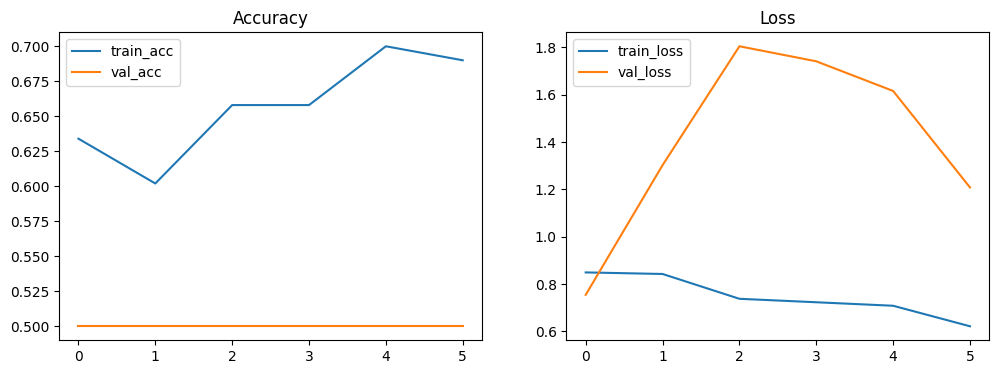

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Ground truth & prediksi
val_dir = os.path.join(WORK_DIR, 'val')
y_true = val_gen.classes
y_pred_prob = model.predict(val_gen)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=val_gen.class_indices.keys()))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 555ms/step
Classification Report:
              precision    recall  f1-score   support

        cats       0.50      1.00      0.67        25
        dogs       0.00      0.00      0.00        25

    accuracy                           0.50        50
   macro avg       0.25      0.50      0.33        50
weighted avg       0.25      0.50      0.33        50

Confusion Matrix:
[[25  0]
 [25  0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


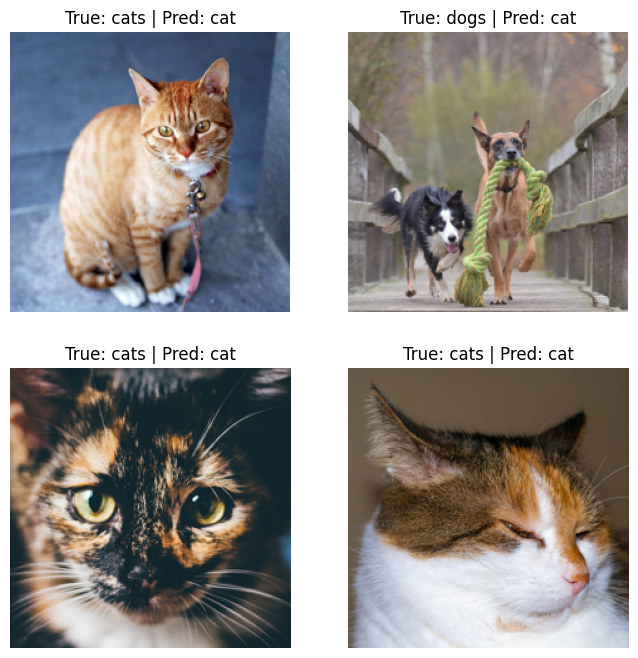

In [ ]:
import random
plt.figure(figsize=(8,8))
for i in range(4):
    idx = random.randint(0, len(val_gen.filenames)-1)
    img_path = os.path.join(val_gen.directory, val_gen.filenames[idx])
    img = Image.open(img_path).resize(img_size)
    plt.subplot(2,2,i+1)
    plt.imshow(img)
    title = f"True: {img_path.split(os.path.sep)[-2]} | Pred: {'dog' if y_pred[idx]==1 else 'cat'}"
    plt.title(title)
    plt.axis('off')

plt.show()

## Summary:

### Data Analysis Key Findings

* The error "ValueError: The PyDataset has length 0" was caused because the `ImageDataGenerator.flow_from_directory` function could not find any image files in the specified directories.
* Inspection of the `DATA_DIR` revealed that the images were located in `train` and `test` subdirectories, which further contained `cats` and `dogs` subdirectories, rather than directly in the root of `DATA_DIR`.
* The initial attempt to re-split the data using `validate_and_split_data` with incorrect source directories resulted in empty output directories.
* The issue was resolved by updating the `ImageDataGenerator.flow_from_directory` paths to point directly to the existing `train` and `test` subdirectories within `DATA_DIR`.
* After correcting the data generator paths, the training data generator (`train_gen`) successfully found 500 images, and the validation data generator (`val_gen`) found 50 images.
* The model training commenced successfully with the correctly configured data generators.

### Insights or Next Steps

* The data loading and preparation steps are now correctly configured, allowing for successful model training.
* Monitor the training and validation metrics to evaluate the model's performance and identify potential overfitting or underfitting.
